<a href="https://colab.research.google.com/github/Viktor-Sok/Bioinformatics/blob/main/Solubility_prediction_with_TensorFlow/NN_in_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install RDKit. Takes 2-3 minutes
%%capture
!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!time bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
!time conda install -q -y -c conda-forge python=3.7
!time conda install -q -y -c conda-forge rdkit=2020.09.02
import sys #system-specific parameters and functions
sys.path.append('/usr/local/lib/python3.7/site-packages/') #specifies the search path for modules

In [ ]:
from rdkit import Chem
from rdkit.Chem.EState import Fingerprinter
from rdkit.Chem import Descriptors, PandasTools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
#from keras.models import Sequential
#from keras.layers import Dense, Activation
#from keras.optimizers import SGD

In [ ]:
print(tf.__version__) # check the TensorFlow version

2.4.1


## Loading the data

In [ ]:
data = pd.read_table("https://raw.githubusercontent.com/Viktor-Sok/Bioiformatics/main/Solubility_prediction_with_TensorFlow/Solub_set.txt", sep = " ")

In [ ]:
data.head(3)

,name,smiles,solubility
0,60-35-5,CC(N)=O,1.58
1,60-34-4,CNN,1.34
2,64-19-7,CC(O)=O,1.22


In [ ]:
data.shape

(1311, 3)

,name,smiles,solubility,molecule
0,60-35-5,CC(N)=O,1.58,
1,60-34-4,CNN,1.34,
2,64-19-7,CC(O)=O,1.22,

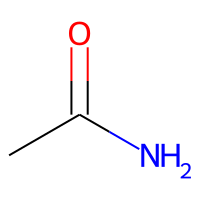
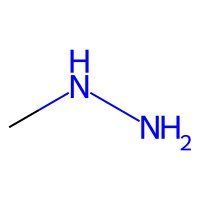
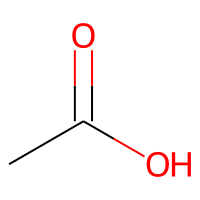

In [ ]:
PandasTools.AddMoleculeColumnToFrame(data,'smiles','molecule') # adds molecule RDKit objects in the column 'molecule'
data.head(3)


In [ ]:
def EStateFingerprints (mol): #returns EState fingerprint for a RDKit molecule object
  return Fingerprinter.FingerprintMol(mol)[0]

In [ ]:
data["EState_fingerprint"] = data["molecule"].apply(EStateFingerprints) # adds column with fingerprints
data["Molecule's_weight"] = data ["molecule"].apply(Descriptors.MolWt) #adds column with molecular weight of the molecules

,name,smiles,solubility,molecule,EState_fingerprint,Molecule's_weight
0,60-35-5,CC(N)=O,1.58,,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...",59.068

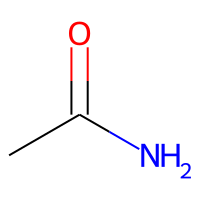

In [ ]:
data.head(1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  


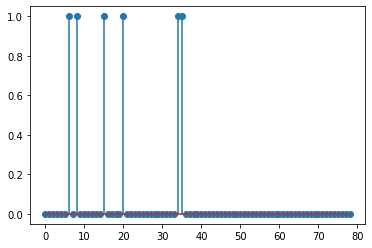

In [ ]:
#ESTate fingerprint visualization
plt.stem(data.EState_fingerprint[20])
plt.show()


## Preparing the training and testing dataset in scikit-learn

In [ ]:
# features (descriptors) for the model
temp = np.array(list(data["EState_fingerprint"]))
X = np.zeros((temp.shape[0],temp.shape[1]+1))
for k,elem in enumerate(temp):
  X[k] = np.append(elem, data["Molecule's_weight"].values[k] )
X.shape

(1311, 80)

In [ ]:
Y = data['solubility'].values # labels (targets) for the model

In [ ]:
#Scale X to unit variance and zero mean
st = StandardScaler()
X= st.fit_transform(X)
#Divide into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

## Defining architecture of the model in Keras

In [ ]:
# We will use sequential model with 1 hidden layer of 5 neurons (small size of neurons prevents overfitting if regularization is not used)
# the output layer of 1 neuron and linear activation fucntion (to predict positive value of solubility).
model = keras.Sequential(
    [   keras.Input(shape=(80,)),  # shape of input is an array with 80 elements which encodes a molecule
        layers.Dense(5, activation="sigmoid", name="hiden_layer"), # hidden layer with 5 neurons
        layers.Dense(1, activation='linear') # output layer with 1 neuron
    ]
)



In [ ]:
model.summary() # descripton of the model structure

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hiden_layer (Dense)          (None, 5)                 405       
_________________________________________________________________
dense (Dense)                (None, 1)                 6         
Total params: 411
Trainable params: 411
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# choosing loss (cost) function, optimizer (stochastic gradient descent), and some other parameters
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=False, name='SGD')
model.compile(loss='mean_squared_error', optimizer =  optimizer)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
Traceback (most recent call last):
  File "/usr/local/bin/tensorboard", line 5, in <module>
    from tensorboard.main import run_main
ModuleNotFoundError: No module named 'tensorboard'

#Training the model

In [ ]:
history = model.fit(X_train, Y_train, epochs=500, batch_size=32) # process of training is saved in the Keras hisroty object

Epoch 1/500
31/31 [==============================] - 0s 988us/step - loss: 0.2472
Epoch 2/500
31/31 [==============================] - 0s 911us/step - loss: 0.2488
Epoch 3/500
31/31 [==============================] - 0s 901us/step - loss: 0.2455
Epoch 4/500
31/31 [==============================] - 0s 1ms/step - loss: 0.2574
Epoch 5/500
31/31 [==============================] - 0s 857us/step - loss: 0.2502
Epoch 6/500
31/31 [==============================] - 0s 929us/step - loss: 0.2450
Epoch 7/500
31/31 [==============================] - 0s 935us/step - loss: 0.2436
Epoch 8/500
31/31 [==============================] - 0s 869us/step - loss: 0.2476
Epoch 9/500
31/31 [==============================] - 0s 846us/step - loss: 0.2503
Epoch 10/500
31/31 [==============================] - 0s 797us/step - loss: 0.2472
Epoch 11/500
31/31 [==============================] - 0s 1ms/step - loss: 0.2462
Epoch 12/500
31/31 [==============================] - 0s 1ms/step - loss: 0.2453
Epoch 13/500
31/31 

##Using  graphs dashboard for examining the TensorFlow model

In [ ]:
!tensorboard --logdir logs

Traceback (most recent call last):
  File "/usr/local/bin/tensorboard", line 5, in <module>
    from tensorboard.main import run_main
ModuleNotFoundError: No module named 'tensorboard'


## Model evaluation (validation) in the case of overfitting

In [ ]:
X_test.shape

(328, 80)

In [ ]:
test_loss = model.evaluate(X_test, Y_test, batch_size = 32,  verbose=1) 
print('Test loss:', test_loss)




11/11 [==============================] - 0s 1ms/step - loss: 0.7743
Test loss: 0.7743154168128967


##Predictions on the testing dataset

In [ ]:
Y_pred = model.predict(X_test, batch_size = 32, verbose=1 ) 

11/11 [==============================] - 0s 1ms/step


In [ ]:
#root mean square error
rms = (np.mean((Y_test.reshape(-1,1) - Y_pred)**2))**0.5
print ('RMS error: ', rms)

RMS error:  0.841156298099735


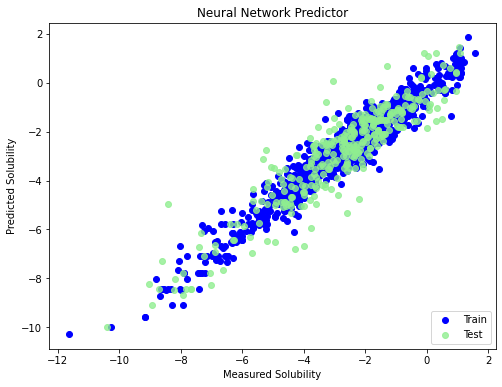

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.scatter(Y_train,model.predict(X_train), label = 'Train', c='blue')
plt.title('Neural Network Predictor')
plt.xlabel('Measured Solubility')
plt.ylabel('Predicted Solubility')
plt.scatter(Y_test,Y_pred, c='lightgreen', label='Test', alpha = 0.8)
plt.legend(loc=4)
#plt.show()